In [ ]:
genes <- read.table("genes", header = FALSE, stringsAsFactors = FALSE)
genes


In [12]:

# 读取 Srufi.v20210930.bed 文件
bed_data <- read.table("Srufi.v20210930.bed", header = FALSE, stringsAsFactors = FALSE)
colnames(bed_data) <- c("Chromosome", "Start", "End", "Gene", "Score", "Strand")  # 设置列名
head(bed_data)


,Chromosome,Start,End,Gene,Score,Strand
,<chr>,<int>,<int>,<chr>,<int>,<chr>
1,Chr01,30717,30957,Srufi.01G000010,0,-
2,Chr01,65230,75322,Srufi.01G000020,0,+
3,Chr01,75535,79161,Srufi.01G000030,0,-
4,Chr01,97856,98510,Srufi.01G000040,0,+
5,Chr01,122541,126601,Srufi.01G000050,0,-
6,Chr01,128680,129863,Srufi.01G000060,0,+


In [13]:
genes <- read.table("genes", header = FALSE, stringsAsFactors = FALSE)
genes <- genes$V1 
library(dplyr)
filtered_bed_data <- bed_data %>%
  filter(Gene %in% genes)  # 筛选 genes 中存在的基因
print(filtered_bed_data)


  Chromosome    Start      End            Gene Score Strand
1      Chr02 68013075 68014275 Srufi.02G023890     0      -
2      Chr03 78626674 78633019 Srufi.03G035420     0      -
3      Chr05 70594641 70609427 Srufi.05G022200     0      -
4      Chr06 36554005 36556749 Srufi.06G007100     0      +
5      Chr06 53594367 53617100 Srufi.06G015570     0      -
6      Chr06 54341568 54342636 Srufi.06G015900     0      -
7      Chr07  9067223  9068398 Srufi.07G005040     0      +
8      Chr07 49104897 49110524 Srufi.07G015510     0      -
9      Chr10 51422574 51423801 Srufi.10G020000     0      -


,Chr,start,End,Node,p,g,t
,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>
1,Chr02,7199495,7199500,24631236,0.00067919,GZZTF,SCS
2,Chr02,14384418,14384438,26034441,0.00070535,GZZTF,SCS
3,Chr02,15150850,15150860,26186068,0.00041615,GZZTF,SCS
4,Chr02,15207927,15207930,26195714,0.00035911,GZZTF,SCS
5,Chr02,15395899,15395941,26231462,0.00022012,GZZTF,SCS
6,Chr02,15425150,15425151,26235372,0.00028512,GZZTF,SCS


,Chr,start,End,Node,p,g,t
,<chr>,<int>,<int>,<int>,<dbl>,<chr>,<chr>
1205937,Chr01,117730299,117730299,23479142,0.00031707,ZZZTF,SCJ
1205938,Chr01,117757501,117757501,23488020,0.00021115,ZZZTF,SCJ
1205939,Chr01,117801310,117801310,23497797,0.00066176,ZZZTF,SCJ
1205940,Chr01,117827816,117827816,23506225,0.00052894,ZZZTF,SCJ
1205941,Chr01,117915707,117915707,23521820,0.00010319,ZZZTF,SCJ
1205942,Chr01,117923632,117923632,23522628,0.00074877,ZZZTF,SCJ


Warning message:
“Removed 103776 rows containing missing values or values outside the scale range (`geom_point()`).”


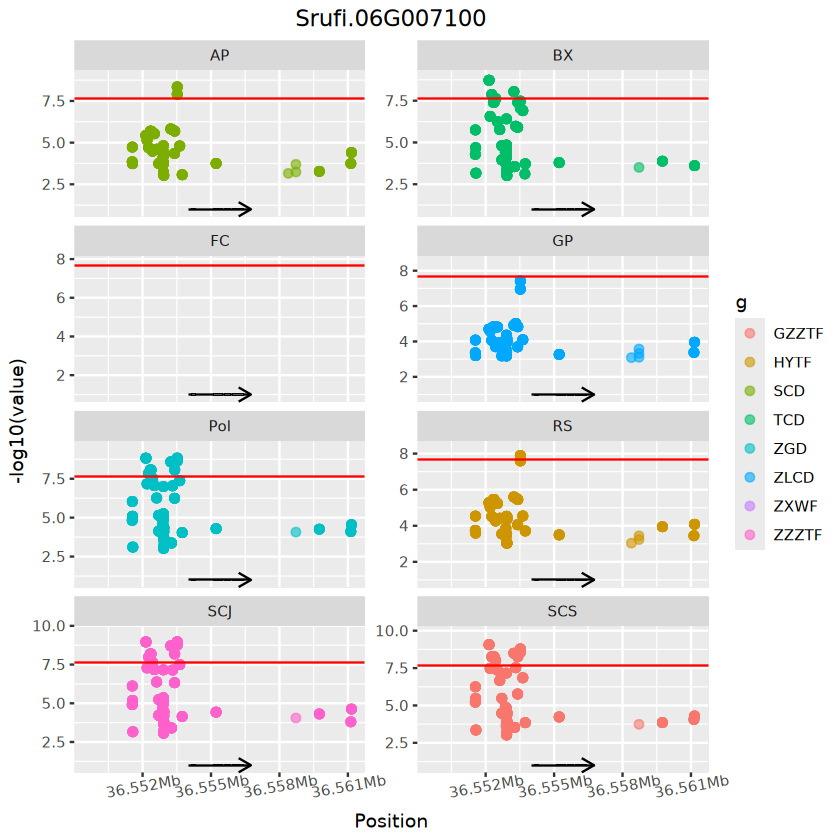

In [14]:
library(ggplot2)
library(dplyr)

# 定义文件名列表
a <- c("GZZTF", "HYTF", "SCD", "TCD", "ZGD", "ZLCD", "ZXWF", "ZZZTF")

n <- 0
# 循环读取文件并合并数据
for (i in a) {
  d <- read.table(paste0(i, ".position"), header = T)
  d$g <- i  
  colnames(d) <- c("Chr", "start", "End", "Node", "p", "g")
  
  # 合并数据
  if (n == 0) {
    out <- d
    n <- 1
  } else {
    out <- rbind(out, d)
  }
}
out <- out %>%
  mutate(t = case_when(
    g == "GZZTF" ~ "SCS",
    g == "HYTF" ~ "RS",
    g == "SCD" ~ "AP",
    g == "TCD" ~ "BX",
    g == "ZGD" ~ "Pol",
    g == "ZLCD" ~ "GP",
    g == "ZXWF" ~ "FC",
    g == "ZZZTF" ~ "SCJ",
    TRUE ~ NA_character_  # 默认值（如果没有匹配项）
  ))

# 查看数据框
head(out)
tail(out)

# 绘制基因图并添加散点图
selected_gene <- "Srufi.06G007100"  # 选择一个基因
gene_data <- filtered_bed_data %>% filter(Gene == selected_gene)
x_range <- c(min(gene_data$Start) - 5000, max(gene_data$End) + 5000)

# 创建基因图并按性状分面
f = ggplot() +  
  # 绘制 mRNA 的箭头线段，处理正负链
  geom_segment(data = gene_data,
               mapping = aes(x = Start, y = 1, xend = End, yend = 1),
               arrow = arrow(length = unit(0.3, "cm"), ends = ifelse(gene_data$Strand == "+", "last", "first")),
               color = "black") +
  
  # 绘制 exon 区域的矩形
  geom_rect(data = filter_cds_bed_data %>% filter(Gene == selected_gene),
            aes(xmin = Start, ymin = 1 - 0.03, xmax = End, ymax = 1 + 0.03),
            colour = "black", alpha = 1, size = 0.2) +
  
  # 添加散点图，绘制每个文件的 p 值
  geom_point(data = out %>% filter(Chr == gene_data$Chr), 
             aes(x = start, y = -log10(p), color = g),  # 根据性状分配颜色
             alpha = 0.6, size = 2) +
  geom_hline(yintercept=-log10(1/45592180), colour="red") + 
  # 设置坐标轴和范围
  scale_x_continuous(expand = c(0, 0), limits = x_range,labels = function(x) sprintf("%.3fMb", x  / 1000000)) +  # 自由的X轴范围
  
  labs(x = "Position", y = "-log10(value)", title = selected_gene) +
  
  # 分面绘制：按性状 (g) 分面
  facet_wrap(~ t, nrow = 4,scales = "free_y") +
  
  # 设置标题居中
  theme(axis.text.x = element_text(hjust = 0.5,angle = 10),
        plot.title = element_text(hjust = 0.5))  # 设置标题居中

# 打印图形
print(f)